In [ ]:
import os
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import string
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, f1_score

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
# For handling warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Download the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir('/content/drive/MyDrive/Topics in DS Final/NN Dataset')

Mounted at /content/drive/


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir('/content/drive/MyDrive/Topics in DS Final/')


with open('./Vectorized Dataset/X_train_preproc.pkl', 'rb') as file:
    X_train_preproc = pickle.load(file)
with open('./Vectorized Dataset/X_val_preproc.pkl', 'rb') as file:
    X_val_preproc = pickle.load(file)
with open('./Vectorized Dataset/X_test_preproc.pkl', 'rb') as file:
    X_test_preproc = pickle.load(file)


train_data = pd.read_csv('./NN Dataset/train.csv', header=None)
train_data.columns=['polarity', 'title', 'text',]

val_data = pd.read_csv('./NN Dataset/val.csv', header=None)
val_data.columns=['polarity', 'title', 'text',]

test_data = pd.read_csv('./NN Dataset/test.csv')




MessageError: Error: credential propagation was unsuccessful

In [ ]:
train_data = pd.read_csv('./train.csv', header=None)
train_data.columns=['polarity', 'title', 'text',]

val_data = pd.read_csv('./val.csv', header=None)
val_data.columns=['polarity', 'title', 'text',]

test_data = pd.read_csv('./test.csv')

In [ ]:
# get all train data
X_train   = train_data['text']
y_train   = train_data['polarity']

# get val data
X_val    = val_data['text']
y_val    = val_data['polarity']

# get test data
X_test   = test_data['text']
y_test   = test_data['polarity']

print(f"Train Data Shape: {X_train.shape[0]:,}")
print(f"Validation Data Shape: {X_val.shape[0]:,}")
print(f"Test Data Shape: {X_test.shape[0]:,}")

print(" ")
print(f"Number of labels = 1 in train dataset as percentage: {((y_train == 1).sum() / (X_train.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 2 in train dataset as percentage: {((y_train == 2).sum() / (X_train.shape[0])) * 100:0.2f}%")

print(" ")
print(f"Number of labels = 1 in val dataset as percentage: {((y_val == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 2 in val dataset as percentage: {((y_val == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")

print(" ")
print(f"Number of labels = 1 in test dataset as percentage: {((y_test == 1).sum() / (X_test.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 2 in test dataset as percentage: {((y_test == 2).sum() / (X_test.shape[0])) * 100:0.2f}%")

Train Data Shape: 3,600,000
Validation Data Shape: 400,000
Test Data Shape: 33,161
 
Number of labels = 1 in train dataset as percentage: 50.00%
Number of labels = 2 in train dataset as percentage: 50.00%
 
Number of labels = 1 in val dataset as percentage: 50.00%
Number of labels = 2 in val dataset as percentage: 50.00%
 
Number of labels = 1 in test dataset as percentage: 2.45%
Number of labels = 2 in test dataset as percentage: 97.55%


In [ ]:
y_train = y_train.replace({1: 0, 2: 1})
y_val   = y_val.replace({1: 0, 2: 1})
y_test  = y_test.replace({1: 0, 2: 1})

# Cleaning Data

## Preprocessing Helper Functions

In [ ]:
# @title
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', str(text), flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    #added substitutions

    #***********added substitutions***********
    # remove all the special characters
    texter = re.sub(r'\W', ' ', texter)
    # remove all single characters
    texter = re.sub(r'\s+[a-zA-Z]\s+', ' ', texter)
    # Remove single characters from the start
    texter = re.sub(r'\^[a-zA-Z]\s+', ' ', texter)
    # Remove numbers
    texter = re.sub(r'\d+', ' ', texter)
    # Converting to Lowercase
    texter = texter.lower()
    # Remove punctuation
    texter = re.sub(r'[^\w\s]', ' ', texter)
    # Remove parentheses
    texter = re.sub(r'\([^)]*\)', ' ', texter)
    # Remove single quotes
    texter = re.sub(r'\'', ' ', texter)
    # Substituting multiple spaces with single space
    texter = re.sub(r'\s+', ' ', texter, flags=re.I)

    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

In [ ]:
def pre_process(data):

    ps = PorterStemmer()

    preproc_data = data.copy()
    preproc_data = preproc_data.str.lower()

    mapping = str.maketrans("", "", string.punctuation)
    preproc_data = preproc_data.str.translate(mapping)

    stop_words = set(stopwords.words('english'))

    preproc_data = preproc_data.apply(lambda text: ' '.join([word for word in str(text).split() if word.lower() not in stop_words]))

    preproc_data = preproc_data.apply(lambda text: ' '.join([ps.stem(word) for word in text.split()]))

    preproc_data = preproc_data.apply(lambda text: clean(text))
    return preproc_data

# get the preprocessed data
# X_train_preproc   = pre_process(X_train)
# X_val_preproc = pre_process(X_val)
# X_test_preproc = pre_process(X_test)

# with open('X_train_preproc_nn.pkl', 'wb') as f:
#     pickle.dump(X_train_preproc, f)

# with open('X_val_preproc_nn.pkl', 'wb') as f:
#     pickle.dump(X_val_preproc, f)

# with open('X_test_preproc_nn.pkl', 'wb') as f:
#     pickle.dump(X_test_preproc, f)

# Vectorizer (Tokenizer)

In [ ]:
with open('X_train_preproc_nn.pkl', 'rb') as f:
    X_train_preproc = pickle.load(f)

with open('X_val_preproc_nn.pkl', 'rb') as f:
    X_val_preproc = pickle.load(f)

with open('X_test_preproc_nn.pkl', 'rb') as f:
    X_test_preproc = pickle.load(f)

In [ ]:
vocab_size = 5000
embedding_dim = 64
max_length = 256
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(X_train_preproc)

In [ ]:
X_train = tokenizer.texts_to_sequences(X_train_preproc)
X_test  = tokenizer.texts_to_sequences(X_test_preproc)
X_val   = tokenizer.texts_to_sequences(X_val_preproc)

In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding=padding_type, truncating=trunc_type, maxlen=max_length)
X_test  = tf.keras.preprocessing.sequence.pad_sequences(X_test,  padding=padding_type, truncating=trunc_type, maxlen=max_length)
X_val   = tf.keras.preprocessing.sequence.pad_sequences(X_val,   padding=padding_type, truncating=trunc_type, maxlen=max_length)

In [ ]:
input_dim = X_train.shape[1]

# Modelling

## ANN

In [ ]:
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, input_dim=input_dim, activation='relu'),
tf.keras.layers.Dropout(0.25, name="dropout"),
tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=METRICS)

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, shuffle=True, callbacks=[early_stop], validation_data=(X_val, y_val) )

Epoch 1/10
56250/56250 ━━━━━━━━━━━━━━━━━━━━ 94s 2ms/step - accuracy: 0.8623 - loss: 0.3209 - precision: 0.8609 - recall: 0.8643 - val_accuracy: 0.8693 - val_loss: 0.3028 - val_precision: 0.8673 - val_recall: 0.8720
Epoch 2/10
56250/56250 ━━━━━━━━━━━━━━━━━━━━ 94s 2ms/step - accuracy: 0.8731 - loss: 0.2966 - precision: 0.8724 - recall: 0.8741 - val_accuracy: 0.8736 - val_loss: 0.2953 - val_precision: 0.8799 - val_recall: 0.8654
Epoch 3/10
56250/56250 ━━━━━━━━━━━━━━━━━━━━ 95s 2ms/step - accuracy: 0.8803 - loss: 0.2825 - precision: 0.8792 - recall: 0.8816 - val_accuracy: 0.8763 - val_loss: 0.2900 - val_precision: 0.8666 - val_recall: 0.8895
Epoch 4/10
56250/56250 ━━━━━━━━━━━━━━━━━━━━ 94s 2ms/step - accuracy: 0.8873 - loss: 0.2682 - precision: 0.8863 - recall: 0.8884 - val_accuracy: 0.8792 - val_loss: 0.2854 - val_precision: 0.8733 - val_recall: 0.8870
Epoch 5/10
56250/56250 ━━━━━━━━━━━━━━━━━━━━ 94s 2ms/step - accuracy: 0.8935 - loss: 0.2561 - precision: 0.8921 - recall: 0.8954 - val_accura

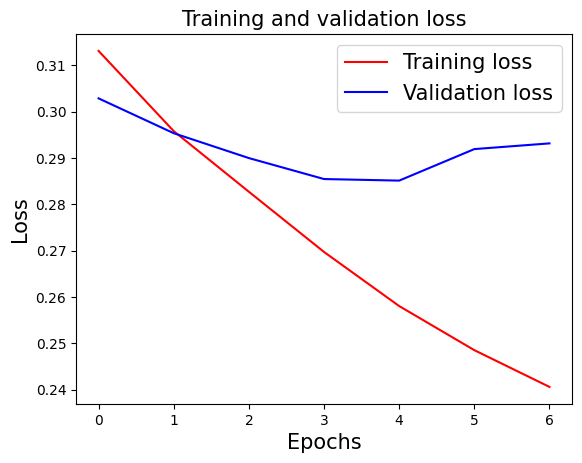

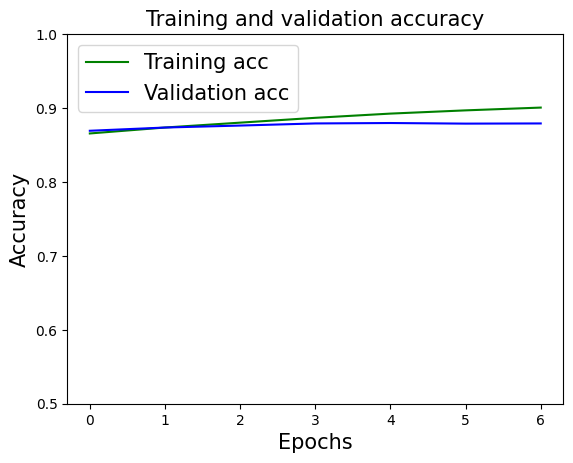

In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

# plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss', size=15)
plt.legend(prop={'size': 15})
plt.show()

# plt.figure(figsize=(10,6))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Accuracy', size=15)
plt.legend(prop={'size': 15})
plt.ylim((0.5,1))
plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

print("---Test Set Results---")
print("Accuracy: {}".format(accuracy_score(y_test, binary_predictions)))
print(classification_report(y_test, binary_predictions))

1037/1037 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
---Test Set Results---
Accuracy: 0.9170411024999247
              precision    recall  f1-score   support

           0       0.20      0.83      0.33       812
           1       1.00      0.92      0.96     32349

    accuracy                           0.92     33161
   macro avg       0.60      0.87      0.64     33161
weighted avg       0.98      0.92      0.94     33161



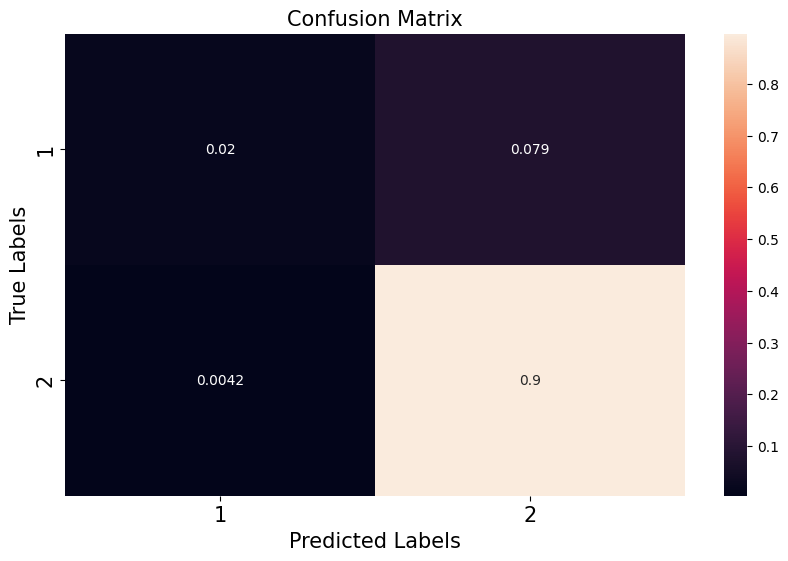

In [ ]:
import seaborn as sns

matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([1,2], size=15)
ax.yaxis.set_ticklabels([1,2], size=15);

## LSTM

In [ ]:
inputs = tf.keras.Input(shape=(max_length,))

# Embedding Layer
x = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)(inputs)

# Bidirectional LSTM
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(x)

# Attention: For self-attention, query = value = x
attention_out = tf.keras.layers.Attention()([x, x])

# Global Max Pooling
x = tf.keras.layers.GlobalMaxPooling1D()(attention_out)

# Dense Layers
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.25)(x)

# Output Layer
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Build the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=METRICS)

In [ ]:
history = model.fit(X_train, y_train, epochs=5, batch_size=64, shuffle=True,
                    callbacks=[early_stop], validation_data=(X_val, y_val),)

Epoch 1/5
56250/56250 ━━━━━━━━━━━━━━━━━━━━ 1205s 21ms/step - accuracy: 0.8370 - loss: 0.3534 - precision: 0.8315 - recall: 0.8494 - val_accuracy: 0.8806 - val_loss: 0.2812 - val_precision: 0.8864 - val_recall: 0.8731
Epoch 2/5
56250/56250 ━━━━━━━━━━━━━━━━━━━━ 1201s 21ms/step - accuracy: 0.8851 - loss: 0.2735 - precision: 0.8844 - recall: 0.8859 - val_accuracy: 0.8890 - val_loss: 0.2633 - val_precision: 0.9104 - val_recall: 0.8630
Epoch 3/5
56250/56250 ━━━━━━━━━━━━━━━━━━━━ 1200s 21ms/step - accuracy: 0.8950 - loss: 0.2531 - precision: 0.8942 - recall: 0.8962 - val_accuracy: 0.8959 - val_loss: 0.2527 - val_precision: 0.9035 - val_recall: 0.8865
Epoch 4/5
56250/56250 ━━━━━━━━━━━━━━━━━━━━ 1215s 22ms/step - accuracy: 0.9004 - loss: 0.2418 - precision: 0.8997 - recall: 0.9014 - val_accuracy: 0.8989 - val_loss: 0.2432 - val_precision: 0.9093 - val_recall: 0.8861
Epoch 5/5
56250/56250 ━━━━━━━━━━━━━━━━━━━━ 1203s 21ms/step - accuracy: 0.9049 - loss: 0.2325 - precision: 0.9045 - recall: 0.9053 - 

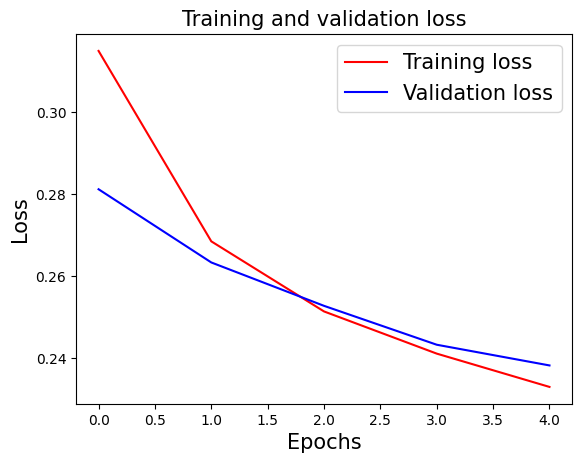

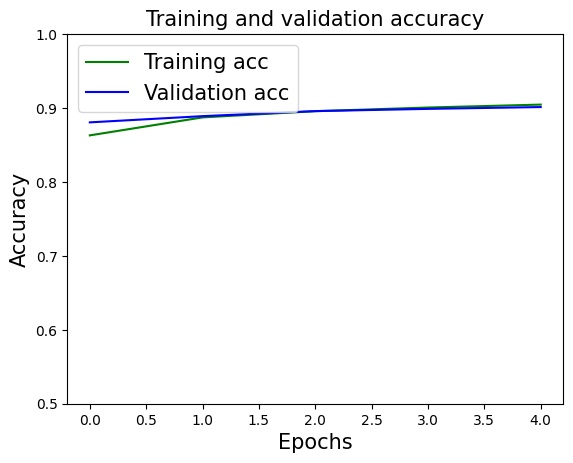

In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

# plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss', size=15)
plt.legend(prop={'size': 15})
plt.show()

# plt.figure(figsize=(10,6))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Accuracy', size=15)
plt.legend(prop={'size': 15})
plt.ylim((0.5,1))
plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

print("---Test Set Results---")
print("Accuracy: {}".format(accuracy_score(y_test, binary_predictions)))
print(classification_report(y_test, binary_predictions))

1037/1037 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
---Test Set Results---
Accuracy: 0.9278369168601671
              precision    recall  f1-score   support

           0       0.23      0.83      0.36       812
           1       1.00      0.93      0.96     32349

    accuracy                           0.93     33161
   macro avg       0.61      0.88      0.66     33161
weighted avg       0.98      0.93      0.95     33161



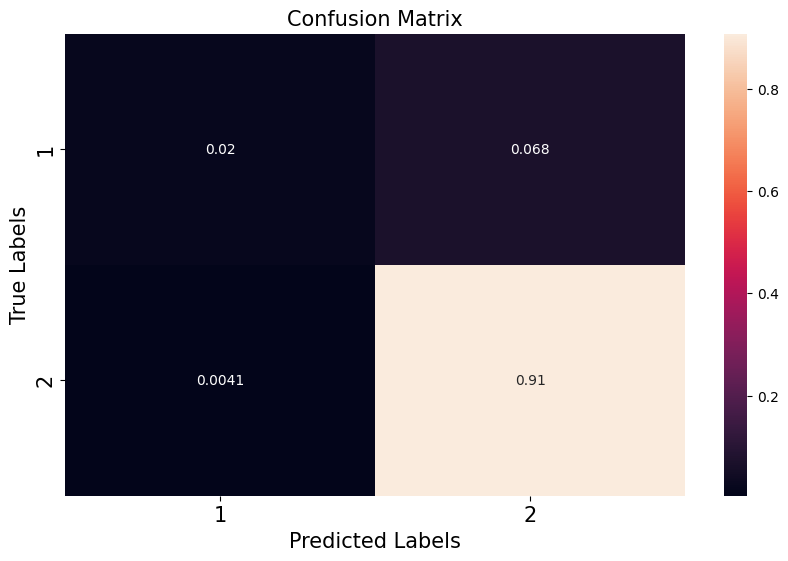

In [ ]:
import seaborn as sns

matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([1,2], size=15)
ax.yaxis.set_ticklabels([1,2], size=15);

# BERT

In [ ]:
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
from tensorflow.keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model

In [ ]:
# Load pretrained transformer model and tokenizer
transformer_model_name = 'distilbert-base-uncased' #"bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(transformer_model_name)
transformer_model = TFAutoModel.from_pretrained(transformer_model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
# Define input parameters
max_length = 128  # Maximum length of the input sequence
vocab_size = tokenizer.vocab_size
embedding_dim = 768  # Output size of BERT's hidden states (depends on the model)
num_classes = 1  # Binary classification (for sentiment analysis)

In [ ]:
# Example preprocessing for text data
def preprocess_data(reviews, tokenizer, max_length):
    tokenized_data = tokenizer(
        reviews.tolist(),
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )
    return tokenized_data["input_ids"], tokenized_data["attention_mask"]

# Tokenize your dataset
X_train_ids, X_train_mask = preprocess_data(X_train_preproc, tokenizer, max_length)
X_val_ids, X_val_mask = preprocess_data(X_val_preproc, tokenizer, max_length)
X_test_ids, X_test_mask = preprocess_data(X_test_preproc, tokenizer, max_length)

In [ ]:
# Build the model
input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

# 1. Transformer Encoder (Pretrained)
transformer_output = transformer_model(input_ids, attention_mask=attention_mask)
sequence_output = transformer_output.last_hidden_state  # Shape: (batch_size, max_length, embedding_dim)
pooled_output = transformer_output.pooler_output  # Shape: (batch_size, embedding_dim)

# 2. Attention Mechanism
attention = tf.keras.layers.Attention()([sequence_output, sequence_output])  # Self-attention

# 3. Conv1D Layer for Local Feature Extraction
conv1d = tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu')(attention)
global_max_pool = tf.keras.layers.GlobalMaxPooling1D()(conv1d)

# 4. Fully Connected Layer
dense = tf.keras.layers.Dense(256, activation='relu')(global_max_pool)
dropout = tf.keras.layers.Dropout(0.4)(dense)

# 5. Output Layer
output = tf.keras.layers.Dense(num_classes, activation='sigmoid')(dropout)

# Compile the Model
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='binary_crossentropy',  # For binary sentiment classification
              metrics=['accuracy'])

# Model Summary
model.summary()

In [ ]:
history = model.fit([X_train_ids, X_train_mask], y_train, validation_data=([X_val_ids, X_val_mask], y_val),
                    epochs=5, batch_size=64, shuffle=True, callbacks=[early_stop])


In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

# plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss', size=15)
plt.legend(prop={'size': 15})
plt.show()

# plt.figure(figsize=(10,6))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Accuracy', size=15)
plt.legend(prop={'size': 15})
plt.ylim((0.5,1))
plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
pred = model.predict([X_test_ids, X_test_mask])

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

print("---Test Set Results---")
print("Accuracy: {}".format(accuracy_score(y_test, binary_predictions)))
print(classification_report(y_test, binary_predictions))

In [ ]:
import seaborn as sns

matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15);